In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'SVR'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/dl-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.svm import SVR

model = SVR()
model

SVR()

In [7]:
p_grid = {
    'C':[.001,.01,.1,.5,1],
    'kernel':['linear','rbf','poly'],
    'gamma':['scale','auto'],
    'degree':[2,3,4],
    'epsilon':[0,.01,.1,.5,1,2]
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  3.3min finished


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'C': 0.5, 'degree': 2, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

C             0.5
degree          2
epsilon         1
gamma       scale
kernel     linear
Name: SVR HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

# Score Model

In [15]:
# MODIFY!
from sklearn.svm import SVR

score_model = SVR(
    C = 0.1,
    degree = 2,
    epsilon = 1, 
    gamma = 'scale',
    kernel = 'linear'
)

score_model

SVR(C=0.1, degree=2, epsilon=1, kernel='linear')

In [16]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [17]:
scores = pd.DataFrame(scores)

In [18]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.191301,0.009548,-3.195266,-17.699767,-4.207109
1,0.158582,0.018159,-3.474789,-20.517861,-4.529665
2,0.482772,0.009067,-3.109666,-17.211603,-4.148687
3,0.130254,0.015240,-3.436905,-19.587518,-4.425779
4,0.123266,0.010462,-3.265165,-18.508574,-4.302159
5,0.114779,0.011034,-3.636945,-24.610034,-4.960850
6,0.122778,0.010590,-3.015813,-15.499553,-3.936947
7,0.128519,0.011019,-2.899207,-13.957507,-3.735975
8,0.113643,0.011481,-2.737006,-12.412477,-3.523135
9,0.121516,0.011644,-3.038619,-17.398389,-4.171138


In [19]:
mean_scores = scores.mean()

In [20]:
mean_scores

fit_time                             0.168741
score_time                           0.011824
test_neg_mean_absolute_error        -3.180938
test_neg_mean_squared_error        -17.740328
test_neg_root_mean_squared_error    -4.194144
dtype: float64

# Export Scores

In [21]:
mean_scores = mean_scores.rename(f'{model_name}')

In [22]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [23]:
# mean_scores

In [24]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [25]:
mean_scores

Fit Time       0.168741
Score Time     0.011824
MAE            3.180938
MSE           17.740328
RMSE           4.194144
Name: SVR, dtype: float64

In [26]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [27]:
mean_scores

Fit Time       0.168741
Score Time     0.011824
MAE            3.180938
MSE           17.740328
RMSE           4.194144
STD FT         0.112884
STD ST         0.002777
STD MAE        0.278120
STD MSE        3.448426
STD RMSE       0.407543
Name: SVR, dtype: float64

In [28]:
mean_scores.to_csv(f'./scores/{model_name}-score.csv')

# Export Optimized Model

In [38]:
# MODIFY! 
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

X_svr = scaler.transform(X)


svr_model = SVR(
    C = 0.5,
    degree = 2,
    epsilon = 1, 
    gamma = 'scale',
    kernel = 'linear'
)

svr_model.fit(X_svr,y)

SVR(C=0.5, degree=2, epsilon=1, kernel='linear')

In [39]:
y_pred_svr = svr_model.predict(X_svr)

<AxesSubplot:ylabel='Count'>

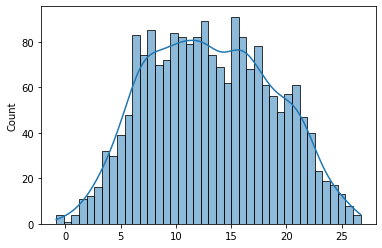

In [40]:
sns.histplot(y_pred_svr,bins=40,kde=True)

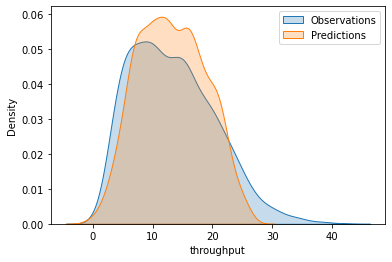

In [41]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred_svr, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

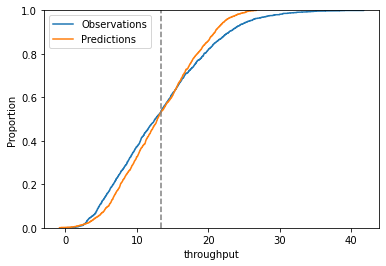

In [42]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred_svr, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y,y_pred_svr)
mse = mean_squared_error(y,y_pred_svr)
rmse = np.sqrt(mse)

In [44]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,SVR
MAE,3.023658
MSE,16.459679
RMSE,4.057053


In [47]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [48]:
from joblib import dump, load
dump(svr_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/SVR-model.joblib']

DONE!